In [16]:
import Pkg; Pkg.add(["StatsPlots","Distributions","LaTeXStrings","Turing","Statistics","StatsBase","DataFrames","CSV","HTTP"])

   Resolving package versions...
┌ Warning: Module Distributions with build ID 40845202530201 is missing from the cache.
│ This may mean Distributions [31c24e10-a181-5473-b8eb-7969acd0382f] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030
┌ Warning: Module Distributions with build ID 40845202530201 is missing from the cache.
│ This may mean Distributions [31c24e10-a181-5473-b8eb-7969acd0382f] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030
   Installed PooledArrays ─ v1.2.1
   Installed DataFrames ─── v1.2.1
  ✓ Turing
   Installed CSV ────────── v0.8.5
    Updating `C:\Users\User\.julia\environments\v1.6\Project.toml`
  [336ed68f] + CSV v0.8.5
  [a93c6f00] + DataFrames v1.2.1
  [cd3eb016] + HTTP v0.8.19
    Updating `C:\Users\User\.julia\environments\v1.6\Manifest.toml`
  [336ed68f] + CSV v0.8.5
  [a93c6f00] + DataFrames v1.2.1
  [2dfb63ee] + PooledArrays v1.2.1
Precompiling project...
  ✓ P

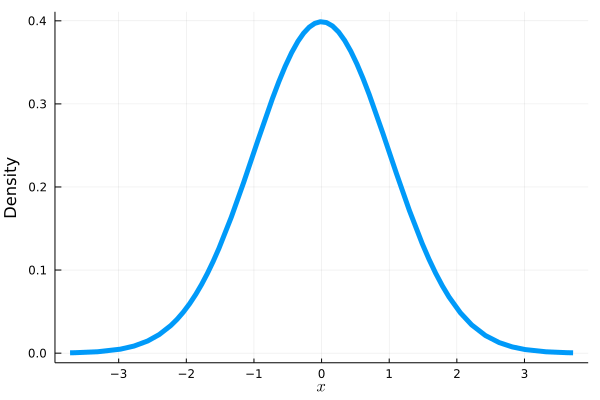

In [8]:
using StatsPlots, Distributions, LaTeXStrings

plot(Normal(0, 1),
        lw=5, label=false,
        xlabel=L"x",
        ylabel="Density")

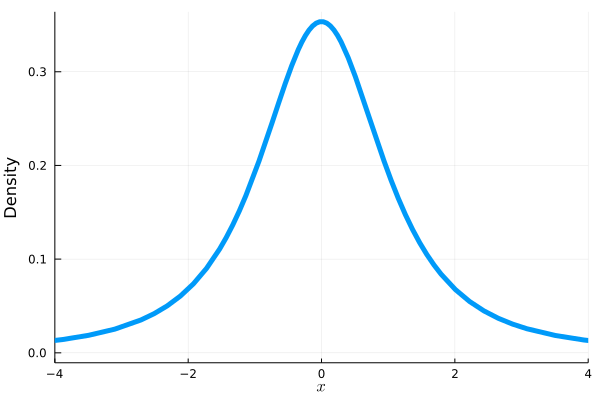

In [9]:
plot(TDist(2),
        lw=5, label=false,
        xlabel=L"x",
        ylabel="Density",
        xlims=(-4, 4))

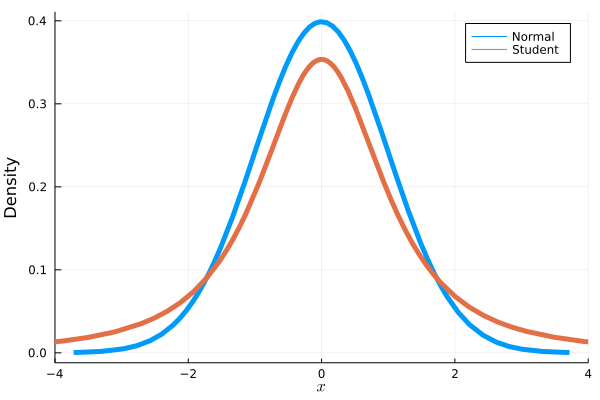

In [10]:
plot(Normal(0, 1),
        lw=5, label="Normal",
        xlabel=L"x",
        ylabel="Density",
        xlims=(-4, 4))
plot!(TDist(2),
        lw=5, label="Student")

In [17]:
using Turing
using Statistics: mean, std
using StatsBase:mad
using Random:seed!
seed!(123)

@model robustreg(X, y; predictors=size(X, 2)) = begin
    #priors
    νₐ ~ LogNormal(1, 1)
    νᵦ ~ LogNormal(1, 1)
    α ~ LocationScale(median(y), 2.5 * mad(y), TDist(νₐ))
    β ~ filldist(TDist(νᵦ), predictors)
    σ ~ Exponential(1)
    ν ~ LogNormal(2, 1)

    #likelihood
    y ~ arraydist(LocationScale.(α .+ X * β, σ, TDist.(ν)))
end;

┌ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
└ @ Base loading.jl:1342
┌ Warning: Module Distributions with build ID 40845202530201 is missing from the cache.
│ This may mean Distributions [31c24e10-a181-5473-b8eb-7969acd0382f] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030
┌ Warning: Module Distributions with build ID 40845202530201 is missing from the cache.
│ This may mean Distributions [31c24e10-a181-5473-b8eb-7969acd0382f] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030
┌ Info: Skipping precompilation since __precompile__(false). Importing Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0].
└ @ Base loading.jl:1047
┌ Info: Precompiling DistributionsAD [ced4e74d-a319-5a8a-b0ac-84af2272839c]
└ @ Base loading.jl:1342
┌ Warning: Module Distributions with build ID 40845202530201 is missing from the cache.
│ This may mean Distributions [31c24e10-a181-5473-b8eb-7969acd0382f] d

In [18]:
using DataFrames, CSV, HTTP

url = "https://raw.githubusercontent.com/storopoli/Bayesian-Julia/master/datasets/duncan.csv"
duncan = CSV.read(HTTP.get(url).body, DataFrame)
describe(duncan)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,profession,,RR.engineer,,welfare.worker,0,String
2,type,,bc,,wc,0,String
3,income,41.8667,7,42.0,81,0,Int64
4,education,52.5556,7,45.0,100,0,Int64
5,prestige,47.6889,3,41.0,97,0,Int64


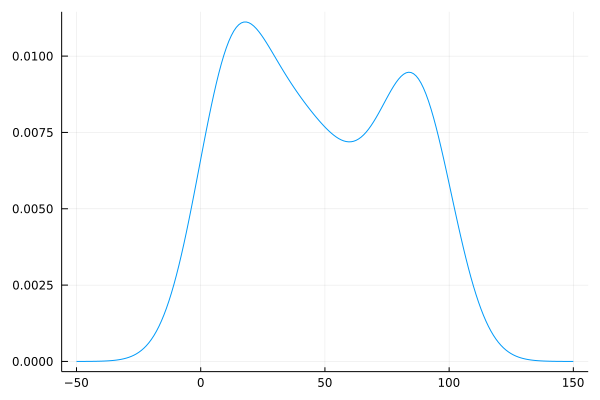

In [19]:
@df duncan density(:prestige, label=false)

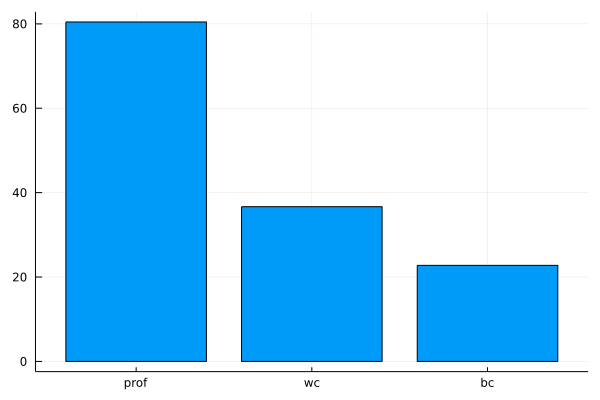

In [20]:
gdf_type = groupby(duncan, :type)
@df combine(gdf_type, :prestige => mean) bar(:type, :prestige_mean, label=false)

In [21]:
X = Matrix(select(duncan, [:income, :education]))
y = duncan[:, :prestige]
model = robustreg(X, y);

In [22]:
chain = sample(model, NUTS(), MCMCThreads(), 2_000, 4)
summarystats(chain)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC C:\Users\User\.julia\packages\AbstractMCMC\BPJCW\src\sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference C:\Users\User\.julia\packages\Turing\YGtAo\src\inference\hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference C:\Users\User\.julia\packages\Turing\YGtAo\src\inference\hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference C:\Users\User\.julia\packages\Turing\YGtAo\src\inference\hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference C:\Users\User\.julia\packages\Turing\YGtAo\src\inference\hmc.jl:188
Sampling (1 threads): 100%|█████████████████████████████| Time: 0:00:11


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          νₐ    4.8970    5.9859     0.0669    0.0788   4983.6933    1.0001    ⋯
          νᵦ    5.3870    6.4775     0.0724    0.0859   5440.3284    0.9998    ⋯
           α   -7.5097    3.0633     0.0342    0.0393   6188.1190    1.0001    ⋯
        β[1]    0.7688    0.1072     0.0012    0.0018   3599.3237    0.9999    ⋯
        β[2]    0.4468    0.0848     0.0009    0.0014   3977.5304    0.9999    ⋯
           σ    7.2814    1.8151     0.0203    0.0293   3192.8300    1.0009    ⋯
           ν    3.1340    3.7512     0.0419    0.0689   2854.3240    1.0014    ⋯
                                                                1 column omitted


In [23]:
quantile(chain)

Quantiles
  parameters       2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol    Float64   Float64   Float64   Float64   Float64 

          νₐ     0.4719    1.6354    3.0984    5.8161   21.7476
          νᵦ     0.6356    1.9525    3.5300    6.4084   21.5797
           α   -13.4476   -9.5591   -7.5318   -5.5014   -1.5102
        β[1]     0.5258    0.7082    0.7750    0.8374    0.9674
        β[2]     0.2842    0.3919    0.4448    0.4982    0.6241
           σ     4.1821    5.9637    7.1171    8.4044   11.2352
           ν     1.0042    1.6351    2.2391    3.2850   11.5303
